In [17]:
import numpy as np
import ROOT
import math as mt
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import f
import scipy
import re


def Line_rotation(m_lor, q_lor, r, angles = None):
    
    coeff = []
    #rotated line from ste formula
    for ang in angles:
        
        m_rot = (m_lor*mt.cos(ang)-mt.sin(ang))/(mt.cos(ang)+m_lor*mt.sin(ang))
        q_rot = (m_lor*r)/(mt.cos(ang)+m_lor*mt.sin(ang))
        coeff.append([m_rot,q_rot])
    
    return coeff[0], coeff[1]


def ellipse_confidence(x, t):
    
    #http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
    
    #calcola la media
    center_x = x[0].mean()
    center_y = x[1].mean()
    #calcolo deviazioni
    s_x = np.std(x[0])
    s_y = np.std(x[1])
    #covariance matrix
    cov = np.cov(x)
    eigenvalues, eigv = np.linalg.eig(cov)
    
    #maj_axis = 2*np.sqrt(2.35*max(eigenvalues))
    #min_axis = 2*np.sqrt(2.35*min(eigenvalues))
    maj_axis = np.sqrt(t*max(eigenvalues))
    min_axis = np.sqrt(t*min(eigenvalues))
    
    i = np.where(eigenvalues==max(eigenvalues))
    max_eigenvector = eigv[:,i]
    
    theta = mt.atan(max_eigenvector[1][0][0]/max_eigenvector[0][0][0])
    
    return [center_x, center_y], maj_axis, min_axis, theta

In [2]:
#computing lor #MAIN
alphas = np.radians([46.78, 304.0, 100.1, 138.6, 59.87])
betas = np.radians([284.9, 12.6, 263.6, 240.6, 278.4])
psi_vec = np.radians([157.5, 142.5, 187.5, 210.0, 165.0])
x_true = 1.16
y_true = -13.25
rotated_lines = []

for al,be, ps in zip(alphas, betas, psi_vec):
    
    r = 0.32645
    cotan = 1 / mt.tan(ps/2)
    q = -0.32645*cotan
    m = mt.sin(ps)/(mt.cos(ps)-1)
    coeff1, coeff2 = Line_rotation(m, q,r, angles = [al, be])
    rotated_lines.append(coeff1)
    rotated_lines.append(coeff2)

draw_points = []
already_done = []
for co in rotated_lines:
    already_done.append(co)
    m = co[0]
    q = co[1]
    other_lines = [x for x in rotated_lines if x != co and x not in already_done]
    
    for ot_co in other_lines:
        m1 = ot_co[0]
        q1 = ot_co[1]
        
        x_int = (q1-q)/(m-m1)
        y_int = m*x_int+q
        draw_points.append([x_int*100, y_int*100])

x = [i[0] for i in draw_points]
y = [i[1] for i in draw_points]

x_cov = np.array([[i[0], i[1]] for i in draw_points]).T

x_avg = np.mean(x)
y_avg = np.mean(y)

x_std = np.std(x)
y_std = np.std(y)

x1 = np.array([x_avg, y_avg])
x_real = np.array([x_true, y_true])

x_t = x1-x_real

#now we implement hotelling for two sample statistics:
#POOLED COVARIANCE MATRIX
n1 = len(x)
n2 = 1
p = 2
cov_1 = np.cov(x_cov, rowvar = True)
cov_2 = np.array([[0.04,0],[0,0.04]])

b = x_t.T
cov_pooling = ((n1-1)*cov_1+(n2-1)*cov_2)/(n1+n2-2)
Sinv = inv(cov_pooling)


t = ((n1*n2)/(n1+n2))*(b.dot(Sinv.dot(x_t)))

#defining Fischer F
F = (n1+n2-p-1)/((n1+n2-2)*p)*t

v1=p
v2=(n1+n2-p-1)
P=1-f.cdf(F,v1,v2)

a = 0.05
if P>= 0.05:
    print('Mean vectors result not significant.')
else:
    print('Mean vectors result significant.')

Mean vectors result not significant.


In [3]:
print(t,F,P)

1.1632669793040564 0.5684145467053913 0.5706206967261431


In [4]:
#NOW WE DO THE SAME WITH THE VALUES FROM THE PAIRED LINES METHOD:
x_paired = [0.6647315155340111, 0.6528186562246899, 0.4926493627791132, 1.2617404216106476, 0.7570001093882107]
y_paired = [-13.076823521140671, -12.668032654288993, -14.850727275337231, -13.34781942915438, -12.874600849995796]

x_paired_joined = []
for i, j in zip(x_paired, y_paired):
    x_paired_joined.append([i,j])

x2 = np.array([np.mean(x_paired), np.mean(y_paired)])

x_t = x2-x_real

#now we implement hotelling for two sample statistics:
#POOLED COVARIANCE MATRIX
n1 = len(x)
n2 = 1
p = 2
cov_1 = np.cov(x_cov, rowvar = True)
cov_2 = np.array([[.04,0],[0,.04]])

b = x_t.T
cov_pooling = ((n1-1)*cov_1+(n2-1)*cov_2)/(n1+n2-2)
Sinv = inv(cov_pooling)


t = ((n1*n2)/(n1+n2))*(b.dot(Sinv.dot(x_t)))

#defining Fischer F
F = (n1+n2-p-1)/((n1+n2-2)*p)*t

v1=p
v2=(n1+n2-p-1)
P=1-f.cdf(F,v1,v2)

a = 0.05
if P>= 0.05:
    print('Mean vectors result not significant.')
else:
    print('Mean vectors result significant.')



Mean vectors result not significant.


In [5]:
print(t,F,P)

0.479623358139229 0.23436141363621418 0.7920796778433243


Info in <TCanvas::Print>: png file ./prova.png has been created


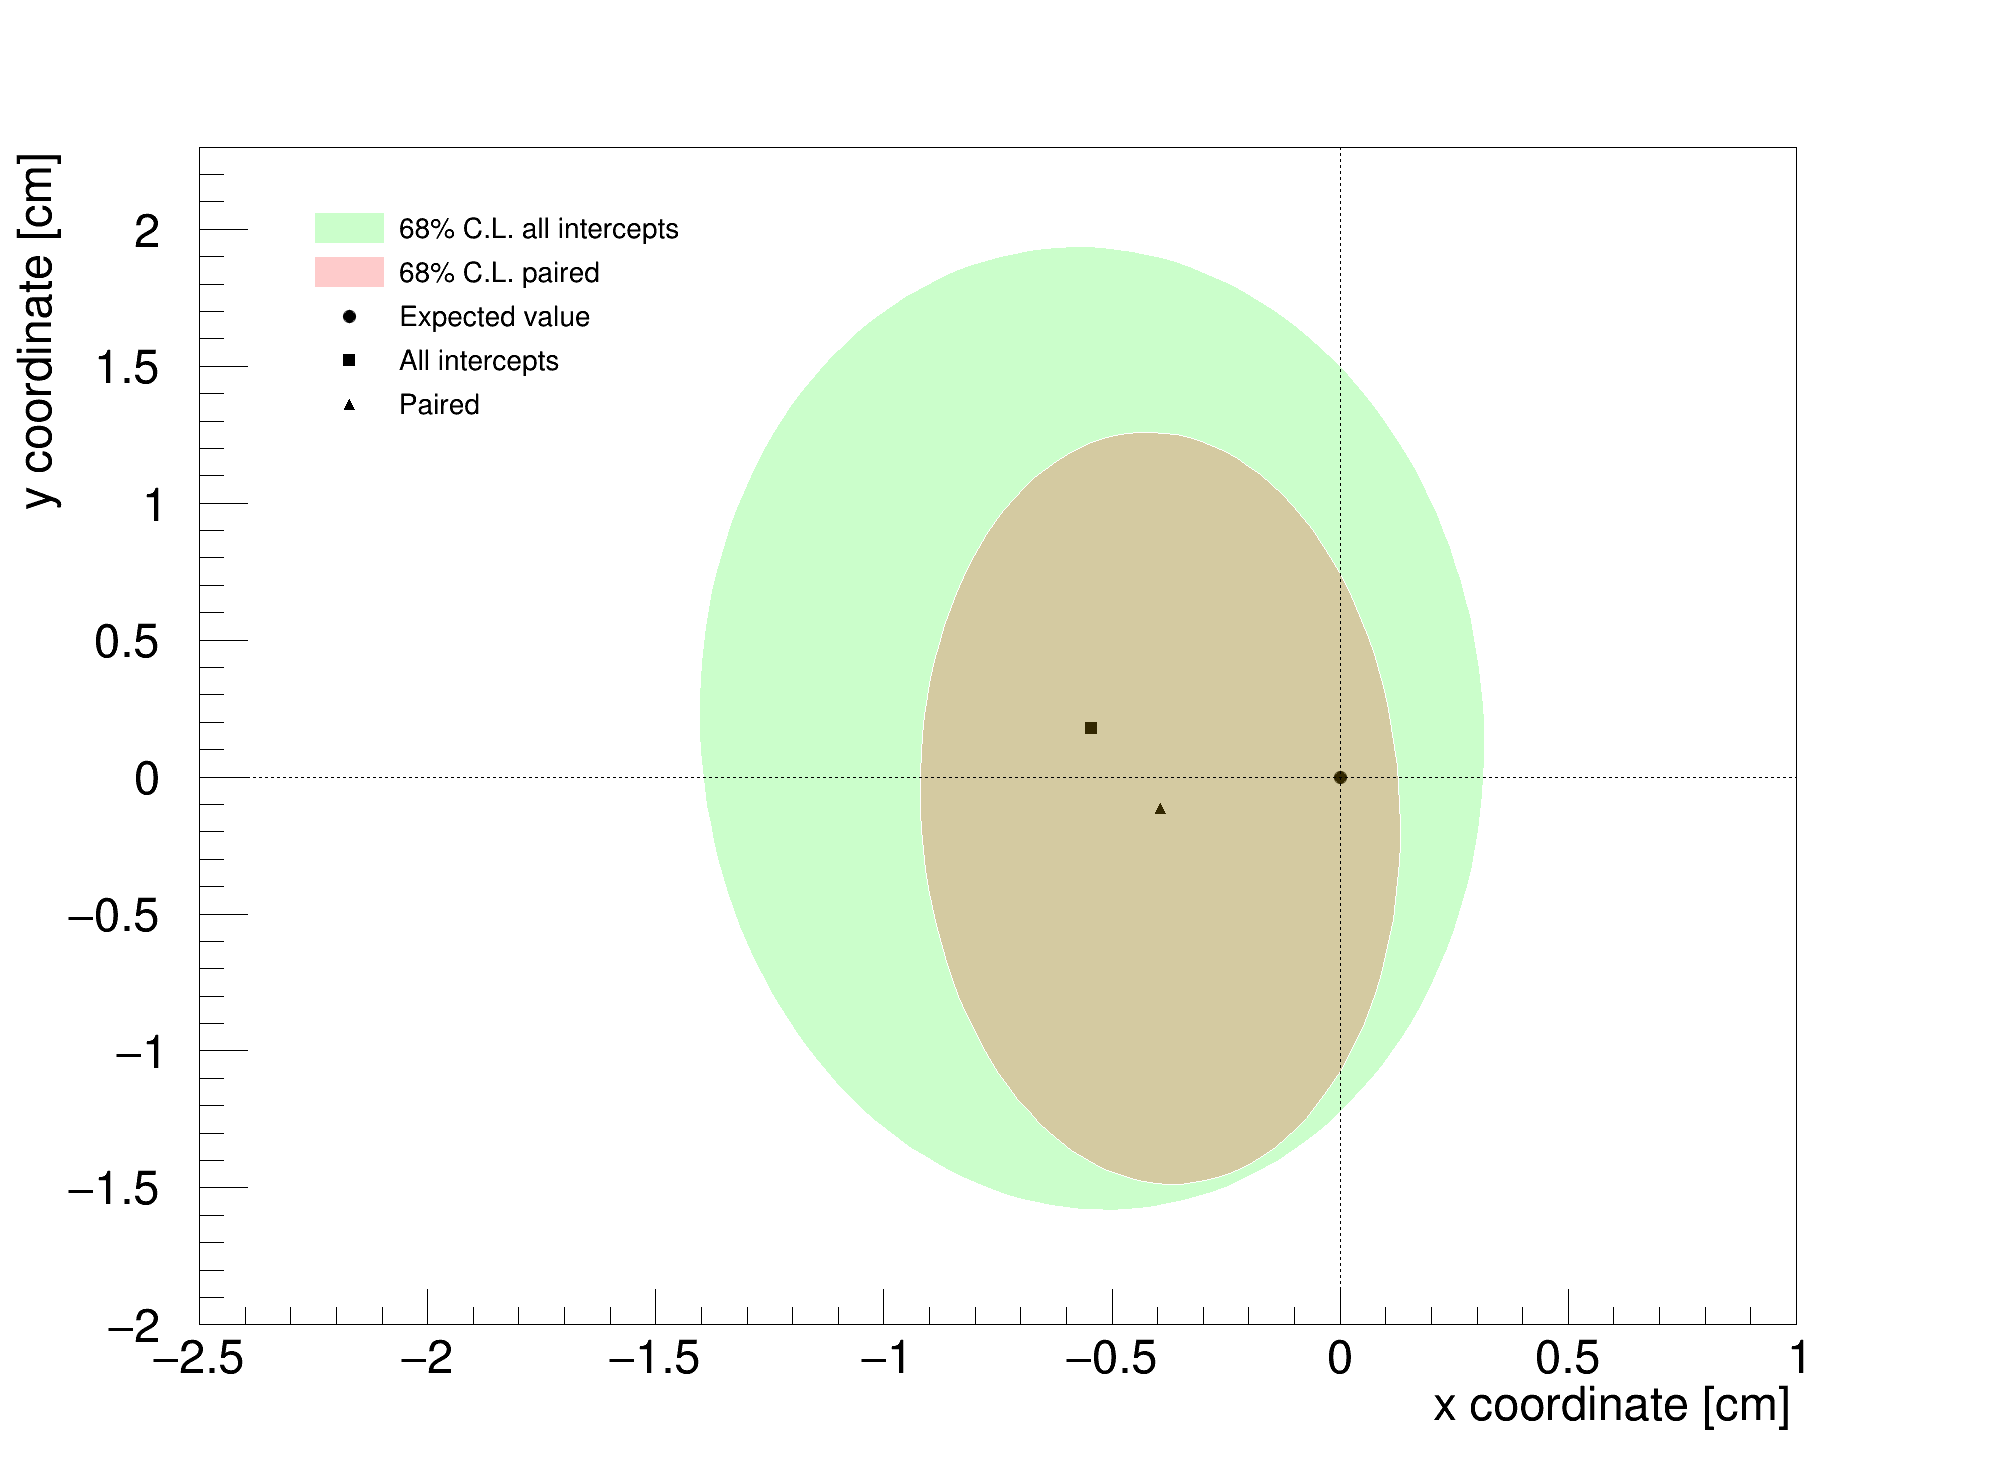

In [6]:
#PLOTTING

c = ROOT.TCanvas("c", "c", 1000,1000,2000,1500)
legend = ROOT.TLegend(0.15,0.71,0.35,0.89)
legend.SetHeader("", "C")
legend.SetLineWidth(0)


#confidence levels 68
[center_x, center_y], maj_axis, min_axis, theta = ellipse_confidence(x_cov, 2.35)

cl = ROOT.TEllipse(center_x,center_y,min_axis,maj_axis,0,360, theta)
cl.SetLineColor(0)
cl.SetFillColorAlpha(ROOT.kGreen, 0.2)
cl.SetFillStyle(1100)
legend.AddEntry(cl,"68% cl all intercepts","f")

#confidence levels 95
[center_x, center_y], maj_axis1, min_axis1, theta1 = ellipse_confidence(x_cov, 5.991)

cl1 = ROOT.TEllipse(center_x,center_y,min_axis1,maj_axis1,0,360, theta1)
cl1.SetLineColor(0)
cl1.SetFillColorAlpha(ROOT.kGreen, 0.2)
cl1.SetFillStyle(1100)
#legend.AddEntry(cl1,"95% cl measured","f")


#confidence level paired
[center_x, center_y], maj_axis1, min_axis1, theta1 = ellipse_confidence(np.array(x_paired_joined).T, 2.35)

cl1 = ROOT.TEllipse(center_x,center_y,min_axis1,maj_axis1,0,360, theta1)
cl1.SetLineColor(0)
cl1.SetFillColorAlpha(ROOT.kBlue, 0.2)
cl1.SetFillStyle(1100)
legend.AddEntry(cl1,"68% cl paired","f")


"""
sigma = ROOT.TBox(x_true-0.2,y_true-0.2,x_true+0.2,y_true+0.2)
sigma.SetLineColor(0)
sigma.SetFillColorAlpha(ROOT.kRed, 0.2)
sigma.SetFillStyle(1100)
legend.AddEntry(sigma,"1#sigma region real", "f")
"""

sigma = ROOT.TEllipse(x_true,y_true,0.2,0.2,0,360, theta1)
sigma.SetLineColor(0)
sigma.SetFillColorAlpha(ROOT.kRed, 0.2)
sigma.SetFillStyle(1100)
legend.AddEntry(sigma,"1#sigma region real","f")


g = ROOT.TGraph(1, np.array(x_avg), np.array(y_avg))
g.SetTitle('')
g.GetXaxis().SetLimits(-1,2)
g.GetXaxis().SetTitle('X[cm]')
g.GetYaxis().SetRangeUser(-16,-10)
g.GetYaxis().SetTitle('Y[cm]')
g.SetMarkerSize(1.5)
g.SetMarkerStyle(20)
legend.AddEntry(g,"Measured, all interception", "p")

g1 = ROOT.TGraph(1, np.array(np.mean(x_paired)), np.array(np.mean(y_paired)))
g1.SetTitle('')
g1.GetXaxis().SetLimits(-1,2)
g1.GetXaxis().SetTitle('X[cm]')
g1.GetYaxis().SetRangeUser(-17,-9)
g1.GetYaxis().SetTitle('Y[cm]')
g1.SetMarkerSize(1.5)
g1.SetMarkerStyle(21)
legend.AddEntry(g1,"Measured, paired lines", "p")

g2 = ROOT.TGraph(1, np.array(x_true), np.array(y_true))
g2.SetTitle('')
g2.GetXaxis().SetLimits(-2,3)
g2.GetXaxis().SetTitle('X[cm]')
g2.GetYaxis().SetRangeUser(-17,-9)
g2.GetYaxis().SetTitle('Y[cm]')
g2.SetMarkerSize(1.5)
g2.SetMarkerStyle(22)
legend.AddEntry(g2,"True value", "p")

real_slit = ROOT.TEllipse(0,0,13.3,13.3)
real_slit.SetLineColor(1)
real_slit.SetLineWidth(1)
real_slit.SetFillStyle(0)
real_slit.SetLineStyle(9)
legend.AddEntry(real_slit,"4th Slit circumference", "l")



#average
m = ROOT.TMarker(x_avg, y_avg, 20)
m.SetMarkerSize(1)
m.SetMarkerColor(ROOT.kBlack)
#real
m_real = ROOT.TMarker(x_true, y_true, 20)
m_real.SetMarkerSize(1)
m_real.SetMarkerColor(ROOT.kBlack)

g.Draw("AP")
g1.Draw("same P")
g2.Draw("same P")
real_slit.Draw("same")
cl.Draw()
cl1.Draw()
sigma.Draw()
legend.Draw()

c.Draw()
c.SaveAs('./prova.png', 'png')


#NOW PLOTTING WITH RESPECT TO THE CENTER FOR BOTH ESTIMATION. PROPAGATION OF ERROR IS DONE THROUGH
#THE SUM OF THE COVARIANCE MATRICES OF THE MEASURED REAL AND THE RECONSTRUCTED ONE.
#WE KNOW THE REAL VALUE IS IN 0,0 DIFFERENCE.

legend = ROOT.TLegend(0.15,0.71,0.35,0.89)
legend.SetHeader("", "C")
legend.SetLineWidth(0)

x_t1 = x1-x_real
x_t2 = x2-x_real

cov_1 = np.cov(x_cov, rowvar = True)
cov_2 = np.cov(np.array(x_paired_joined).T, rowvar = True)
cov_real = np.array([[0.04,0], [0,0.04]])

#fist ellipse

cov_sum_1 = cov_1 + cov_real
eigenvalues1, eigv1 = np.linalg.eig(cov_sum_1)
maj_axis1 = np.sqrt(2.35*max(eigenvalues1))
min_axis1 = np.sqrt(2.35*min(eigenvalues1))
i1 = np.where(eigenvalues1==max(eigenvalues1))
max_eigenvector1 = eigv1[:,i1]
theta1 = mt.atan(max_eigenvector1[1][0][0]/max_eigenvector1[0][0][0])

el1 = ROOT.TEllipse(x_t1[0],x_t1[1],min_axis1,maj_axis1,0,360, theta1)
el1.SetLineColor(0)
el1.SetFillColorAlpha(ROOT.kGreen, 0.2)
el1.SetFillStyle(1100)
legend.AddEntry(el1, "68% C.L. all intercepts", "f")

#second ellipse

cov_sum_2 = cov_2 + cov_real
eigenvalues2, eigv2 = np.linalg.eig(cov_sum_2)
maj_axis2 = np.sqrt(2.35*max(eigenvalues2))
min_axis2 = np.sqrt(2.35*min(eigenvalues2))
i2 = np.where(eigenvalues2==max(eigenvalues2))
max_eigenvector2 = eigv1[:,i2]
theta2 = mt.atan(max_eigenvector2[1][0][0]/max_eigenvector2[0][0][0])

el2 = ROOT.TEllipse(x_t2[0],x_t2[1],min_axis2,maj_axis2,0,360, theta2)
el2.SetLineColor(0)
el2.SetFillColorAlpha(ROOT.kRed, 0.2)
el2.SetFillStyle(1100)
legend.AddEntry(el2, "68% C.L. paired", "f")

g = ROOT.TGraph(1, np.array(0), np.array(0))
g.SetTitle('')
g.GetXaxis().SetLimits(-2.5,1)
g.GetXaxis().SetTitle('x coordinate [cm]')
g.GetYaxis().SetRangeUser(-2,2.3)
g.GetYaxis().SetTitle('y coordinate [cm]')
g.SetMarkerSize(1.5)
g.SetMarkerStyle(20)
g.GetYaxis().SetLabelOffset(0.02)
legend.AddEntry(g,"Expected value", "p")

g1 = ROOT.TGraph(1, np.array(x_t1[0]), np.array(x_t1[1]))
g1.SetTitle('')
g1.GetXaxis().SetLimits(-2,1)
g1.GetXaxis().SetTitle('X[cm]')
g1.GetYaxis().SetRangeUser(-2,2.3)
g1.GetYaxis().SetTitle('y coordinate [cm]')
g1.SetMarkerSize(1.5)
g1.SetMarkerStyle(21)
legend.AddEntry(g1,"All intercepts", "p")

g2 = ROOT.TGraph(1, np.array(x_t2[0]), np.array(x_t2[1]))
g2.SetTitle('')
g2.GetXaxis().SetLimits(-2,1)
g2.GetXaxis().SetTitle('X[cm]')
g2.GetYaxis().SetRangeUser(-2,2.3)
g2.GetYaxis().SetTitle('Y[cm]')
g2.SetMarkerSize(1.5)
g2.SetMarkerStyle(22)
legend.AddEntry(g2,"Paired", "p")

line1 = ROOT.TLine(0,-2,0,2.3)
line1.SetLineStyle(2)

line2 = ROOT.TLine(-2.5,0,1,0)
line2.SetLineStyle(2)

g.Draw("AP")
g1.Draw("same P")
g2.Draw("same P")
el1.Draw()
el2.Draw()
line1.Draw()
line2.Draw()
legend.Draw()

c.Draw()

In [7]:
def ellipse_confidence(x,y, t):
    
    #http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
    
    #calcola la media
    center_x = x.mean()
    center_y = y.mean()
    #calcolo deviazioni
    s_x = np.std(x)
    s_y = np.std(y)
    #covariance matrix
    cov = np.cov(x,y)
    eigenvalues, eigv = np.linalg.eig(cov)
    
    #maj_axis = 2*np.sqrt(2.35*max(eigenvalues))
    #min_axis = 2*np.sqrt(2.35*min(eigenvalues))
    maj_axis = np.sqrt(t*max(eigenvalues))
    min_axis = np.sqrt(t*min(eigenvalues))
    
    i = np.where(eigenvalues==max(eigenvalues))
    max_eigenvector = eigv[:,i]
    
    theta = mt.atan(max_eigenvector[1][0][0]/max_eigenvector[0][0][0])
    
    return [center_x, center_y], maj_axis, min_axis, theta

0.6656490897118947 -13.094874351154512
0.48854625611464125 -12.811120073370805
0.2607249379736941 -12.446104605917437
0.6871721711573856 -13.129358646561856
-0.02190291196524986 -11.993278076764541
1.0425592096804077 -13.698759996057571
0.08200543324092373 -12.159760096565128
1.198086336048922 -13.947945661369015
0.6894830822334619 -13.133061189824973
0.9934832691426757 -12.427157046452525
0.817612068894483 -12.785363271344401
0.6984426985280772 -13.028081864391197
0.3063326359079577 -13.826713278034006
-1.5373420727282592 -17.581823588177016
0.7765470286515412 -12.869002622299528
0.7612721622786575 -12.900113754829679
0.7483325343358536 -12.926468583081013
0.6537197862716249 -12.685519202431417
0.7442232229536734 -12.61669878998719
0.16813309016135172 -13.0547679064463
2.800200290635963 -11.053297498709634
0.6211328479066522 -12.710298886173716
0.6674581656810354 -12.675072295972026
0.8621078491333055 -12.527057237224748
0.7313047084693486 -12.73278435851167
0.03449148425259911 -12.30

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ./allinter_326_cl.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./allinter_326_cl.root has been created


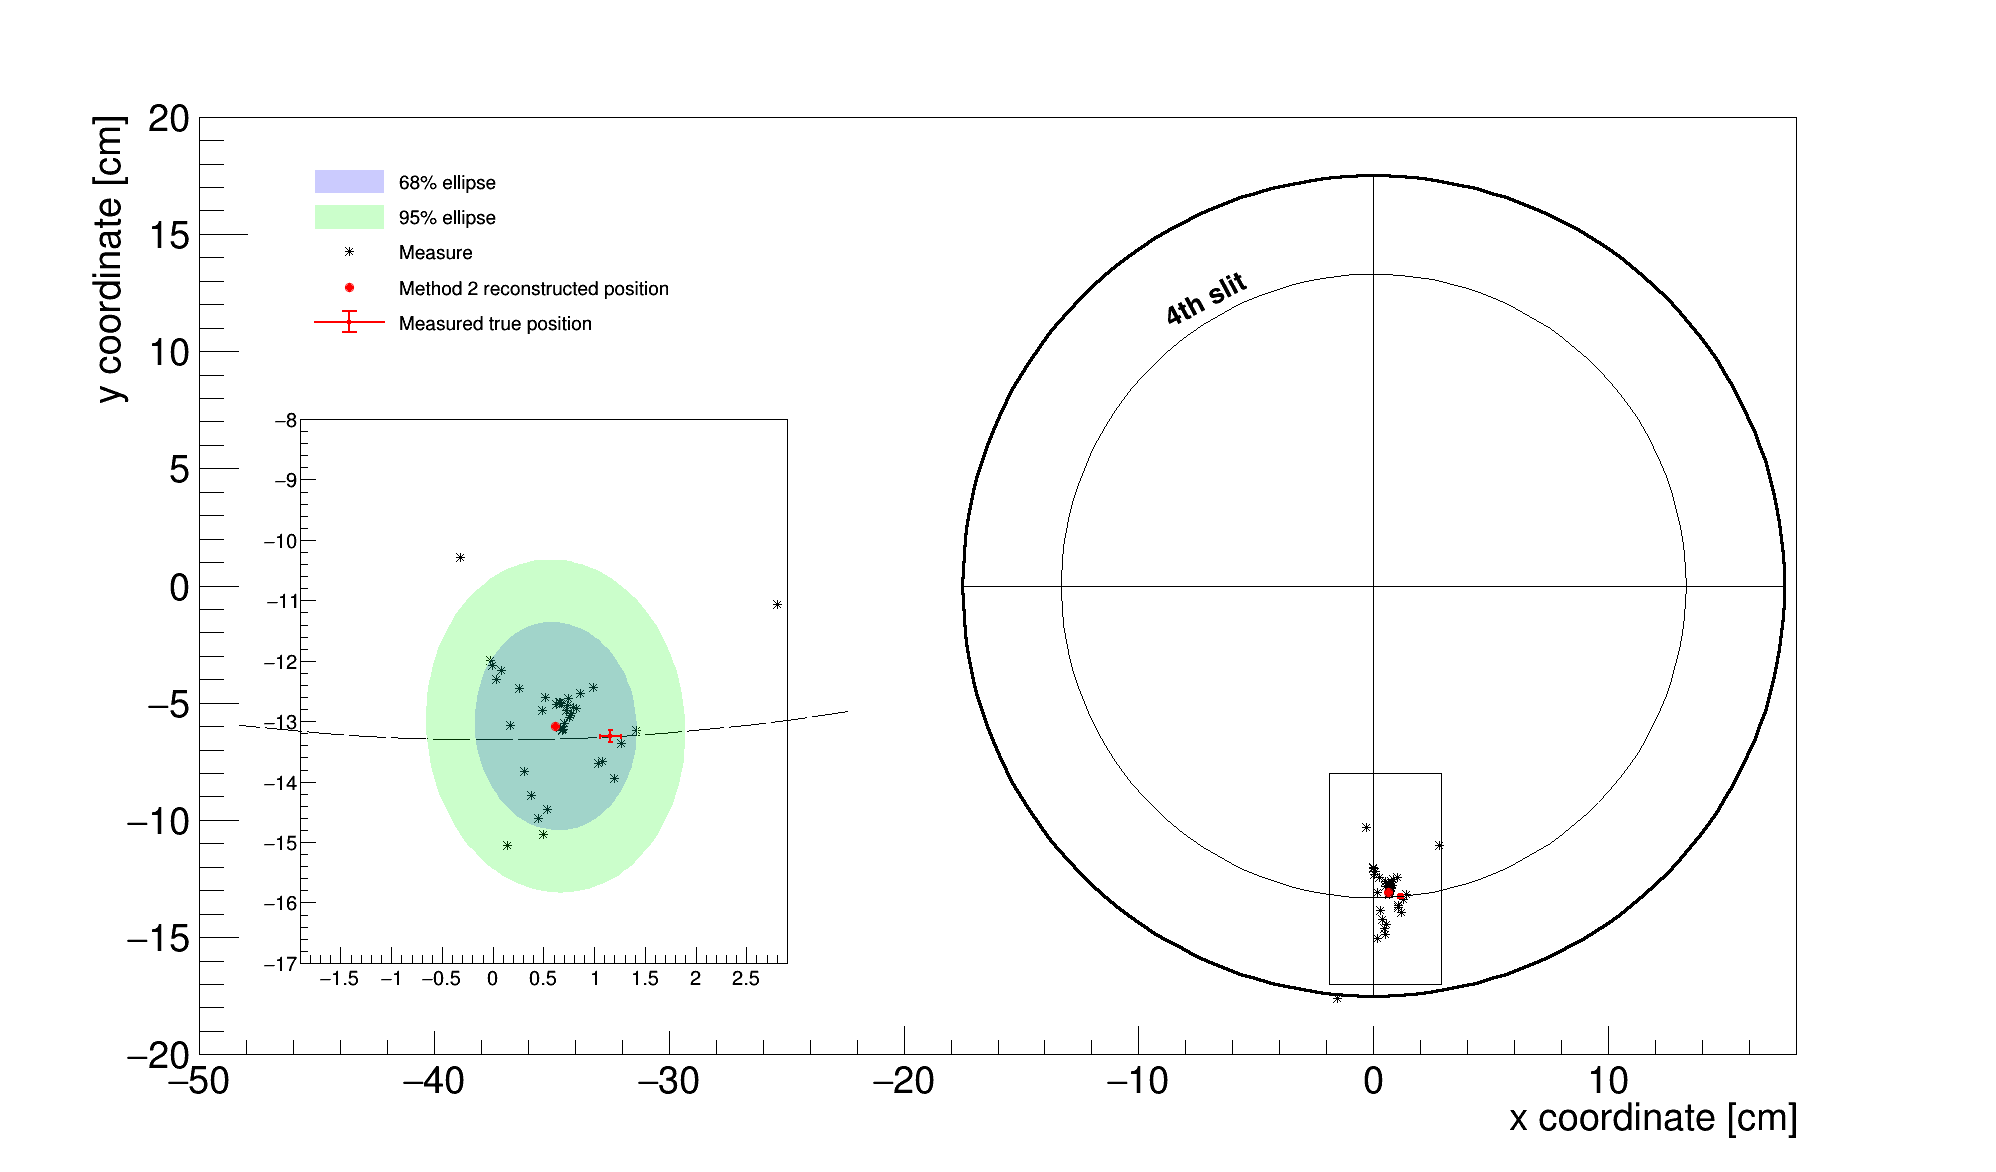

In [8]:
alphas = np.radians([46.78, 304.0, 100.1, 138.6, 59.87])
betas = np.radians([284.9, 12.6, 263.6, 240.6, 278.4])
psi_vec = np.radians([157.5, 142.5, 187.5, 210.0, 165.0])

rotated_lines = []

for al,be, ps in zip(alphas, betas, psi_vec):
    
    r = 0.32645
    cotan = 1 / mt.tan(ps/2)
    q = -0.32645*cotan
    m = mt.sin(ps)/(mt.cos(ps)-1)
    coeff1, coeff2 = Line_rotation(m, q,r, angles = [al, be])
    rotated_lines.append(coeff1)
    rotated_lines.append(coeff2)

draw_points = []
already_done = []
for co in rotated_lines:
    already_done.append(co)
    m = co[0]
    q = co[1]
    other_lines = [x for x in rotated_lines if x != co and x not in already_done]
    
    for ot_co in other_lines:
        m1 = ot_co[0]
        q1 = ot_co[1]
        
        x_int = (q1-q)/(m-m1)
        y_int = m*x_int+q
        print(x_int*100, y_int*100)
        draw_points.append([x_int*100, y_int*100])

x = [i[0] for i in draw_points]
y = [i[1] for i in draw_points]

x_avg = np.mean(x)
y_avg = np.mean(y)

x_std = np.std(x)
y_std = np.std(y)

print(x_avg, '+-', np.std(x)/mt.sqrt(len(x)), y_avg, '+-', np.std(y)/mt.sqrt(len(y)))


"""
fig = plt.figure(figsize=(20,10))
plt.scatter(xs, ys, c = 'blue', s= 5)
plt.scatter(x_avg, y_avg, c = 'red', s = 20)
fig.savefig("./prova4.png")
"""

c = ROOT.TCanvas("c", "c", 1000,1000,2000,1200)
legend = ROOT.TLegend(0.15,0.71,0.35,0.89)
legend.SetHeader("", "C")
legend.SetLineWidth(0)

g = ROOT.TGraph(len(x), np.array(x), np.array(y))
g.SetTitle('')
g.GetXaxis().SetLimits(-50,18)
g.GetYaxis().SetRangeUser(-20,20)
g.GetXaxis().SetTitle("x coordinate [cm]")
g.GetYaxis().SetTitle("y coordinate [cm]")
g.GetYaxis().SetTitleOffset(0.8)
g.SetMarkerSize(1)
g.SetMarkerStyle(ROOT.kStar)

g_sub = ROOT.TGraph(len(x), np.array(x), np.array(y))
g_sub.SetTitle('')
g_sub.GetXaxis().SetLimits(-1.9,2.9)
g_sub.GetYaxis().SetRangeUser(-17,-8)
g_sub.SetMarkerSize(1)
g_sub.SetMarkerStyle(ROOT.kStar)


l1 = ROOT.TLine(-17.5,0,17.5,0)
l2 = ROOT.TLine(0,-17.5,0,17.5)


circle = ROOT.TEllipse(0,0,17.5,17.5)
circle.SetLineColor(1)
circle.SetLineWidth(3)
circle.SetFillStyle(0)

sub_circle = ROOT.TEllipse(0,0,17.5,17.5)
sub_circle.SetLineColor(1)
sub_circle.SetLineWidth(3)
sub_circle.SetFillStyle(0)

real_slit = ROOT.TEllipse(0,0,13.3,13.3)
real_slit.SetLineColor(1)
real_slit.SetLineWidth(1)
real_slit.SetFillStyle(0)
real_slit.SetLineStyle(9)

#confidence levels 68
[center_x, center_y], maj_axis, min_axis, theta = ellipse_confidence(np.array(x), np.array(y), 2.35)

cl = ROOT.TEllipse(center_x,center_y,min_axis,maj_axis,0,360, theta)
cl.SetLineColor(0)
cl.SetFillColorAlpha(ROOT.kBlue, 0.2)
cl.SetFillStyle(1100)
legend.AddEntry(cl,"68% ellipse","f")

#confidence levels 95
[center_x, center_y], maj_axis1, min_axis1, theta1 = ellipse_confidence(np.array(x), np.array(y), 5.991)

cl1 = ROOT.TEllipse(center_x,center_y,min_axis1,maj_axis1,0,360, theta1)
cl1.SetLineColor(0)
cl1.SetFillColorAlpha(ROOT.kGreen, 0.2)
cl1.SetFillStyle(1100)
legend.AddEntry(cl1,"95% ellipse","f")

t1 = ROOT.TLatex(.8,-10.3,"68% ellipse")
t1.SetTextAngle(-45)
t1.SetTextSize(.035)

t2 = ROOT.TLatex(1,-9.5,"95% ellipse")
t2.SetTextAngle(-45)
t2.SetTextSize(.035)

t3 = ROOT.TLatex(-8.6,11,"4th slit")
t3.SetTextSize(.025)
t3.SetTextAngle(28)

zoom_box = ROOT.TBox(-1.9,-17,2.9,-8)
zoom_box.SetLineColor(1)
zoom_box.SetLineWidth(1)
zoom_box.SetFillStyle(0)
zoom_box.SetLineStyle(1)

zoom_sigma = ROOT.TBox(x_avg-x_std,y_avg-y_std,x_avg+x_std,y_avg+y_std)
zoom_sigma.SetLineColor(0)
zoom_sigma.SetFillColorAlpha(ROOT.kBlue, 0.2)
zoom_sigma.SetFillStyle(1100)
#legend.AddEntry(zoom_sigma,"1#sigma region","f")

zoom_2sigma = ROOT.TBox(x_avg-2*x_std,y_avg-2*y_std,x_avg+2*x_std,y_avg+2*y_std)
zoom_2sigma.SetLineColor(0)
zoom_2sigma.SetFillColorAlpha(ROOT.kGreen, 0.2)
zoom_2sigma.SetFillStyle(1100)
#legend.AddEntry(zoom_2sigma,"2#sigma region","f")




legend.AddEntry(g,"Measure","P");


m = ROOT.TMarker(x_avg, y_avg, 20)
m.SetMarkerSize(1)
m.SetMarkerColor(ROOT.kRed)
legend.AddEntry(m,"Method 2 reconstructed position","P")

"""
m1 = ROOT.TMarker(x_true, y_true, 20)
m1.SetMarkerSize(2)
m1.SetMarkerStyle(34)
m1.SetMarkerColor(ROOT.kRed)
legend.AddEntry(m1,"Measured true position","P")
"""

g_real = ROOT.TGraphErrors(1, np.array(x_true), np.array(y_true), np.array(0.1), np.array(0.1))
g_real.SetTitle('')
g_real.SetLineWidth(2)
g_real.GetXaxis().SetLimits(-1.9,2.9)
g_real.GetYaxis().SetRangeUser(-17,-8)
g_real.SetMarkerSize(.5)
g_real.SetMarkerStyle(21)
g_real.SetMarkerColor(ROOT.kRed)
g_real.SetLineColor(ROOT.kRed)
legend.AddEntry(g_real,"Measured true position","Pel")

#drawing
g.Draw('AP')
g_real.Draw('P')
l1.Draw()
l2.Draw()
circle.Draw()
real_slit.Draw()
m.Draw()
zoom_box.Draw()
t3.Draw()
legend.Draw()


subpad = ROOT.TPad("subpad","",0.12,0.12,0.425,0.7)
subpad.Draw()
subpad.cd()
g_sub.Draw('AP')
real_slit.Draw()
#sub_circle.Draw()
cl.Draw()
cl1.Draw()
#cl2.Draw()
#zoom_sigma.Draw()
#zoom_2sigma.Draw()
m.Draw()
g_real.Draw('P')
#t1.Draw()
#t2.Draw()



c.cd()
c.Draw()
c.SaveAs('./allinter_326_cl.png', 'png')
c.SaveAs('./allinter_326_cl.root', 'root')

Best pos 0.7657880131073346+-0.11723911162259827, -13.363600745983415+-0.34738862442035223
x: [0.6647315155340111, 0.6528186562246899, 0.4926493627791132, 1.2617404216106476, 0.7570001093882107]
y: [-13.076823521140671, -12.668032654288993, -14.850727275337231, -13.34781942915438, -12.874600849995796]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ./paired_326_cl.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./paired_326_cl.root has been created


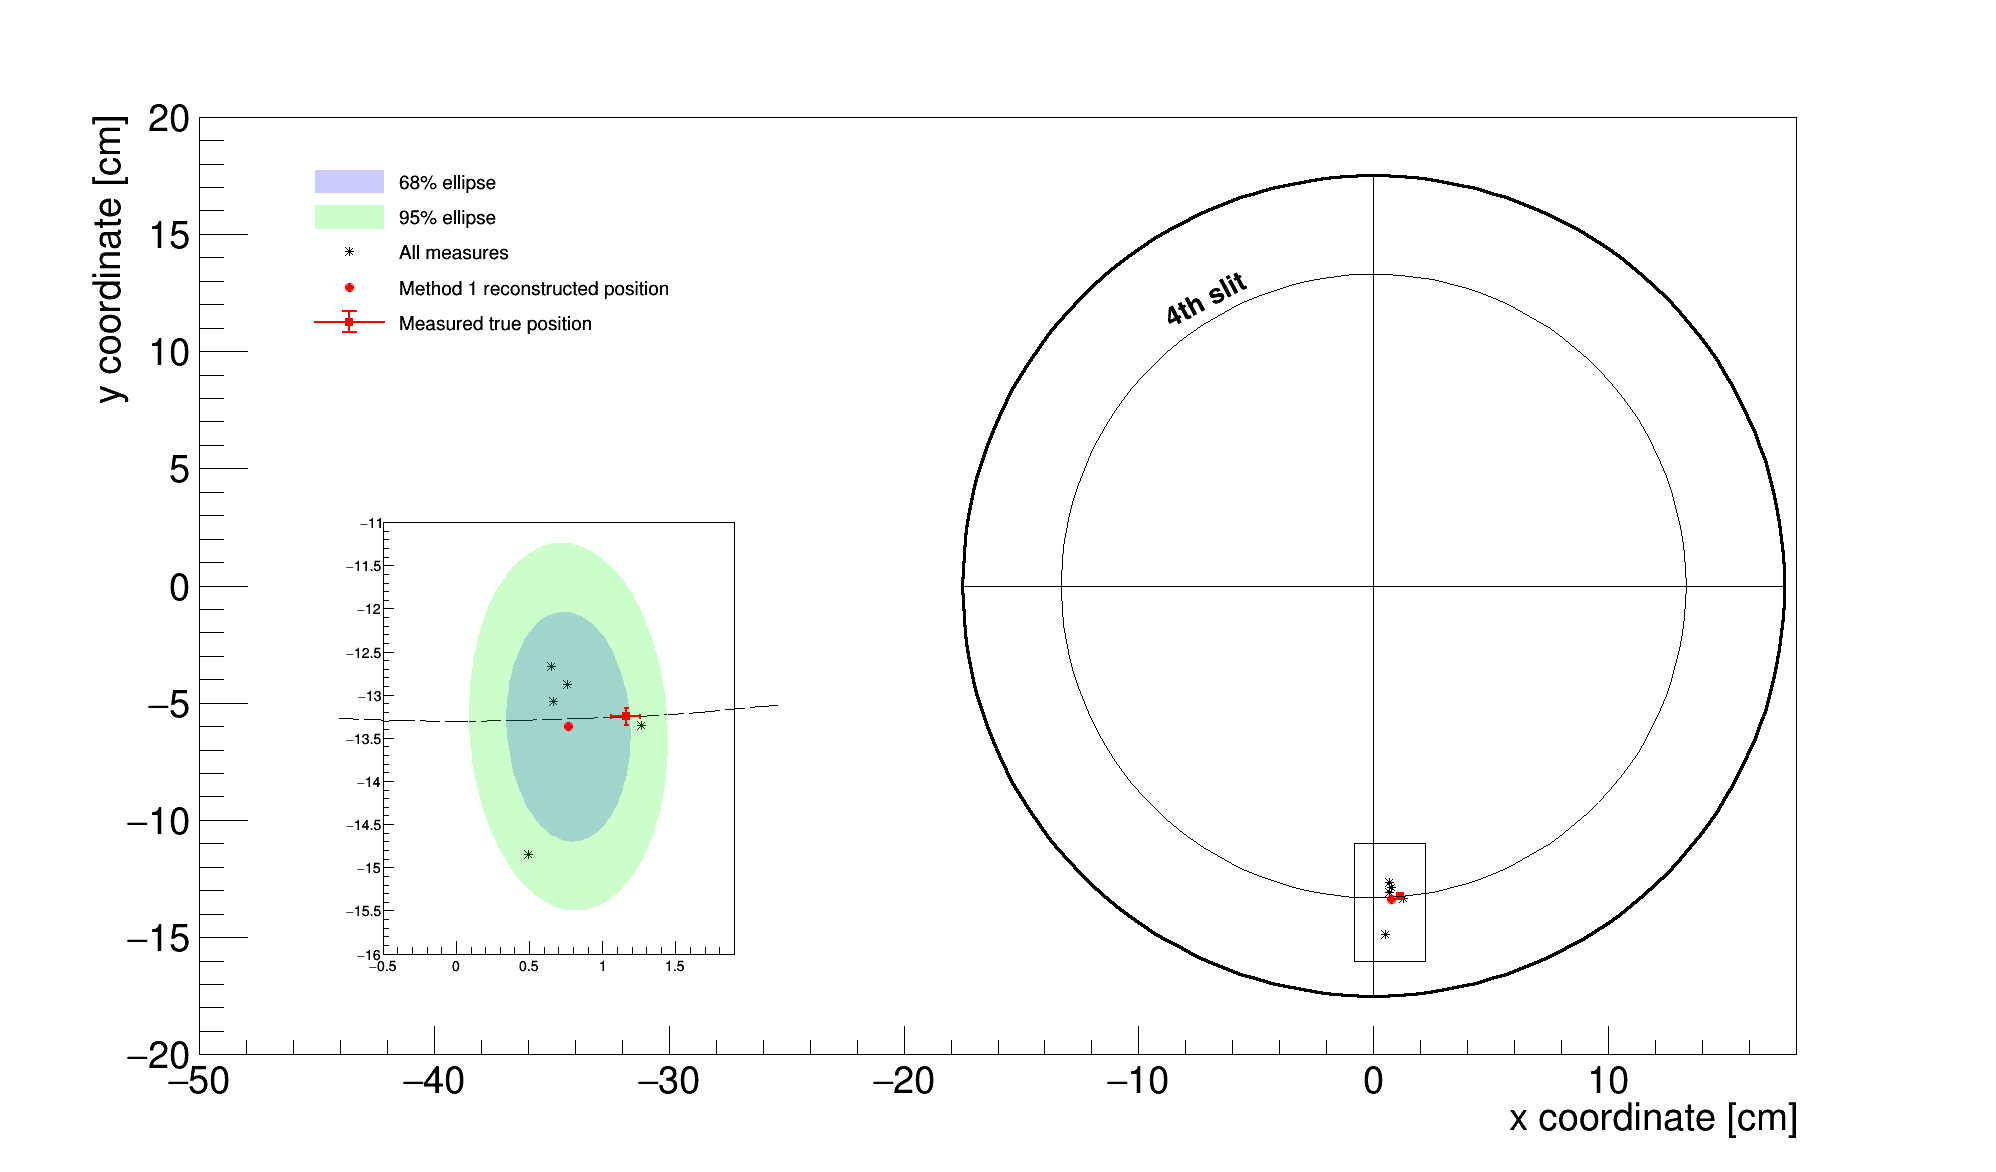

In [9]:
f = open('./positions_bianca.txt', 'r')
lines = f.readlines()
x = []
y = []

for line in lines:
    line = re.split(',|:', line)
    x_pos_ind = line.index(list(l for l in line if 'x' in l)[0])+1
    x_pos = float(line[x_pos_ind])
    x.append(x_pos)
    y_pos_ind = line.index(list(l for l in line if 'y' in l)[0])+1
    y_pos= float(line[y_pos_ind])
    y.append(y_pos)

average_x = np.mean(x)
average_y = np.mean(y)
std_dev_x = np.std(x)
std_dev_y = np.std(y)

print('Best pos {}+-{}, {}+-{}'.format(average_x, std_dev_x/mt.sqrt(len(x)), average_y, std_dev_y/mt.sqrt(len(x))))

print('x:', x)
print('y:', y)
#now plotting everything on the rotating plate:
c = ROOT.TCanvas("c", "c", 1000,1000,2000,1200)
legend = ROOT.TLegend(0.15,0.71,0.35,0.89)
legend.SetHeader("", "C")
legend.SetLineWidth(0)

g = ROOT.TGraph(len(x), np.array(x), np.array(y))
g.SetTitle('')
g.GetXaxis().SetLimits(-50,18)
g.GetXaxis().SetTitle("x coordinate [cm]")
g.GetYaxis().SetTitle("y coordinate [cm]")
g.GetYaxis().SetTitleOffset(0.8)
g.GetYaxis().SetRangeUser(-20,20)
g.SetMarkerSize(1)
g.SetMarkerStyle(ROOT.kStar)

g_sub = ROOT.TGraph(len(x), np.array(x), np.array(y))
g_sub.SetTitle('')
g_sub.GetXaxis().SetLimits(-0.5,1.9)
g_sub.GetYaxis().SetRangeUser(-16,-11)
g_sub.SetMarkerSize(1)
g_sub.SetMarkerStyle(ROOT.kStar)


l1 = ROOT.TLine(-17.5,0,17.5,0)
l2 = ROOT.TLine(0,-17.5,0,17.5)


circle = ROOT.TEllipse(0,0,17.5,17.5)
circle.SetLineColor(1)
circle.SetLineWidth(3)
circle.SetFillStyle(0)

sub_circle = ROOT.TEllipse(0,0,17.5,17.5)
sub_circle.SetLineColor(1)
sub_circle.SetLineWidth(3)
sub_circle.SetFillStyle(0)

real_slit = ROOT.TEllipse(0,0,13.3,13.3)
real_slit.SetLineColor(1)
real_slit.SetLineWidth(1)
real_slit.SetFillStyle(0)
real_slit.SetLineStyle(9)

#confidence levels
[center_x, center_y], maj_axis, min_axis, theta = ellipse_confidence(np.array(x), np.array(y), 2.35)

cl = ROOT.TEllipse(center_x,center_y,min_axis,maj_axis,0,360, theta)
cl.SetLineColor(0)
cl.SetFillColorAlpha(ROOT.kBlue, 0.2)
cl.SetFillStyle(1100)
legend.AddEntry(cl,"68% ellipse","f")

[center_x, center_y], maj_axis1, min_axis1, theta1 = ellipse_confidence(np.array(x), np.array(y), 5.991)

cl1 = ROOT.TEllipse(center_x,center_y,min_axis1,maj_axis1,0,360, theta1)
cl1.SetLineColor(0)
cl1.SetFillColorAlpha(ROOT.kGreen, 0.2)
cl1.SetFillStyle(1100)
legend.AddEntry(cl1,"95% ellipse","f")

t1 = ROOT.TLatex(.8,-11,"68% ellipse")
t1.SetTextAngle(-45)
t1.SetTextSize(.035)

t2 = ROOT.TLatex(1,-10.5,"95% ellipse")
t2.SetTextAngle(-45)
t2.SetTextSize(.035)

t3 = ROOT.TLatex(-8.6,11,"4th slit")
t3.SetTextSize(.025)
t3.SetTextAngle(28)

zoom_box = ROOT.TBox(-0.8,-16,2.2,-11)
zoom_box.SetLineColor(1)
zoom_box.SetLineWidth(1)
zoom_box.SetFillStyle(0)
zoom_box.SetLineStyle(1)

zoom_sigma = ROOT.TBox(average_x-std_dev_x,average_y-std_dev_y,average_x+std_dev_x,average_y+std_dev_y)
zoom_sigma.SetLineColor(0)
zoom_sigma.SetFillColorAlpha(ROOT.kBlue, 0.2)
zoom_sigma.SetFillStyle(1100)
#legend.AddEntry(zoom_sigma,"1#sigma region","f")

zoom_2sigma = ROOT.TBox(average_x-2*std_dev_x,average_y-2*std_dev_y,average_x+2*std_dev_x,average_y+2*std_dev_y)
zoom_2sigma.SetLineColor(0)
zoom_2sigma.SetFillColorAlpha(ROOT.kGreen, 0.2)
zoom_2sigma.SetFillStyle(1100)
#legend.AddEntry(zoom_2sigma,"2#sigma region","f")




legend.AddEntry(g,"All measures","P");


m = ROOT.TMarker(average_x, average_y, 20)
m.SetMarkerSize(1)
m.SetMarkerColor(ROOT.kRed)
legend.AddEntry(m,"Method 1 reconstructed position","P")

"""
m1 = ROOT.TMarker(x_true, y_true, 20)
m1.SetMarkerSize(2)
m1.SetMarkerStyle(34)
m1.SetMarkerColor(ROOT.kRed)
legend.AddEntry(m1,"Measured true position","P")
"""

g_real = ROOT.TGraphErrors(1, np.array(x_true), np.array(y_true), np.array(0.1), np.array(0.1))
g_real.SetTitle('')
g_real.SetLineWidth(2)
g_real.GetXaxis().SetLimits(-1.9,2.9)
g_real.GetYaxis().SetRangeUser(-17,-8)
g_real.SetMarkerSize(1)
g_real.SetMarkerStyle(21)
g_real.SetMarkerColor(ROOT.kRed)
g_real.SetLineColor(ROOT.kRed)
legend.AddEntry(g_real,"Measured true position","Pel")



#drawing
g.Draw('AP')
g_real.Draw("P")
l1.Draw()
l2.Draw()
circle.Draw()
real_slit.Draw()
m.Draw()
zoom_box.Draw()
t3.Draw()
legend.Draw()


subpad = ROOT.TPad("subpad","",0.17,0.14,0.39,0.6)
subpad.Draw()
subpad.cd()
g_sub.Draw('AP')
real_slit.Draw()
sub_circle.Draw()
#zoom_sigma.Draw()
#zoom_2sigma.Draw()
cl.Draw()
cl1.Draw()
m.Draw()
g_real.Draw("P")
#m1.Draw()
#t1.Draw()
#t2.Draw()



c.cd()
c.Draw()
c.SaveAs('./paired_326_cl.png', 'png')
c.SaveAs('./paired_326_cl.root', 'root')

Info in <TCanvas::SaveAs>: ROOT file ./difference_real.root has been created
Info in <TCanvas::Print>: png file ./difference_real.png has been created


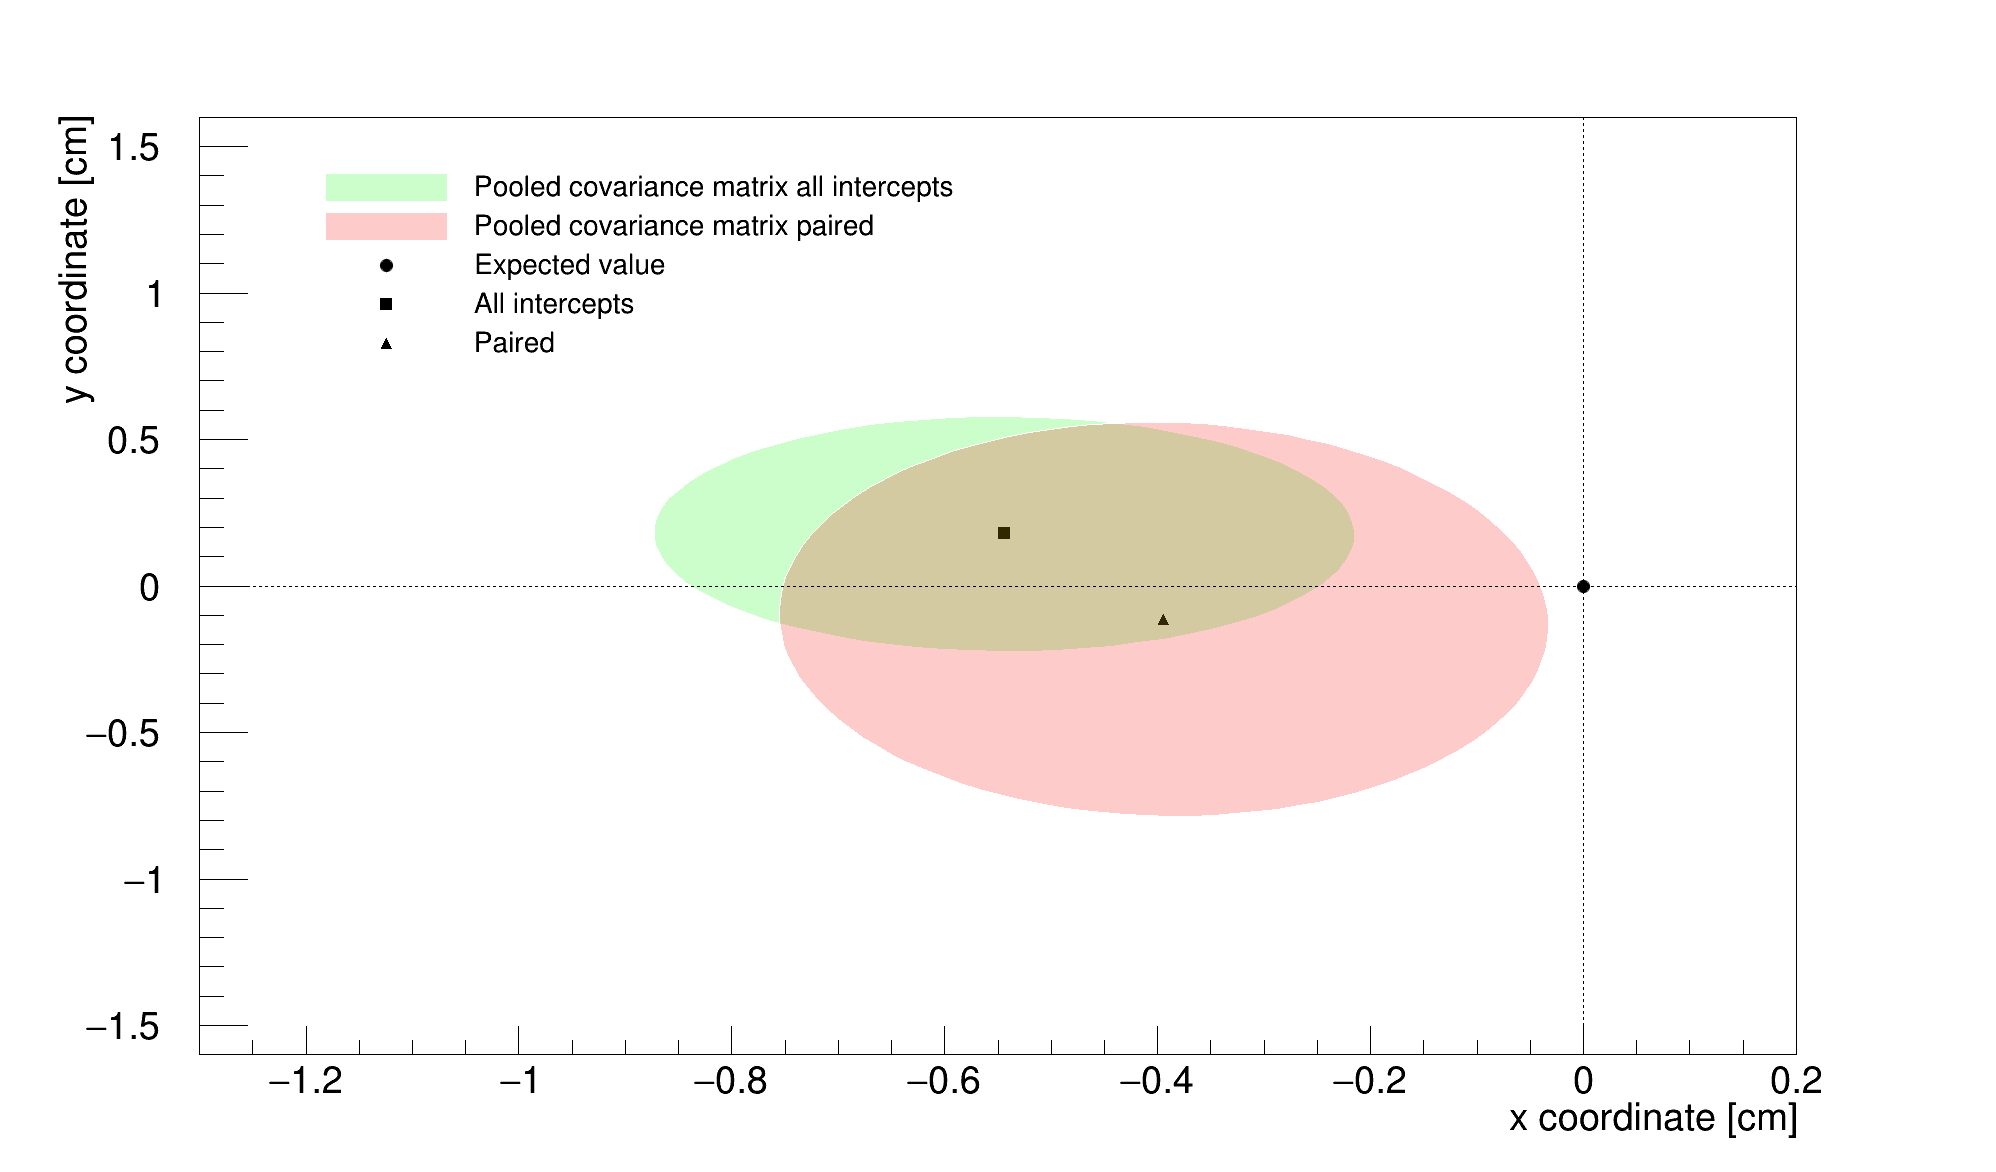

In [10]:
#NOW PLOTTING WITH RESPECT TO THE CENTER FOR BOTH ESTIMATION. PROPAGATION OF ERROR IS DONE THROUGH
#THE SUM OF THE COVARIANCE MATRICES OF THE MEASURED REAL AND THE RECONSTRUCTED ONE.
#WE KNOW THE REAL VALUE IS IN 0,0 DIFFERENCE.

legend = ROOT.TLegend(0.15,0.69,0.5,0.89)
legend.SetHeader("", "C")
legend.SetLineWidth(0)

x_t1 = x1-x_real
x_t2 = x2-x_real

cov_1 = np.cov(x_cov, rowvar = True)/45
cov_2 = np.cov(np.array(x_paired_joined).T, rowvar = True)/5
cov_real = np.array([[0.04,0], [0,0.04]])

#fist ellipse

cov_sum_1 = cov_1 + cov_real
eigenvalues1, eigv1 = np.linalg.eig(cov_sum_1)
maj_axis1 = np.sqrt(2.35*max(eigenvalues1))
min_axis1 = np.sqrt(2.35*min(eigenvalues1))
i1 = np.where(eigenvalues1==max(eigenvalues1))
max_eigenvector1 = eigv1[:,i1]
theta1 = mt.atan(max_eigenvector1[1][0][0]/max_eigenvector1[0][0][0])

el1 = ROOT.TEllipse(x_t1[0],x_t1[1],min_axis1,maj_axis1,0,360, theta1)
el1.SetLineColor(0)
el1.SetFillColorAlpha(ROOT.kGreen, 0.2)
el1.SetFillStyle(1100)
legend.AddEntry(el1, "Pooled covariance matrix all intercepts", "f")

#second ellipse

cov_sum_2 = cov_2 + cov_real
eigenvalues2, eigv2 = np.linalg.eig(cov_sum_2)
maj_axis2 = np.sqrt(2.35*max(eigenvalues2))
min_axis2 = np.sqrt(2.35*min(eigenvalues2))
i2 = np.where(eigenvalues2==max(eigenvalues2))
max_eigenvector2 = eigv1[:,i2]
theta2 = mt.atan(max_eigenvector2[1][0][0]/max_eigenvector2[0][0][0])

el2 = ROOT.TEllipse(x_t2[0],x_t2[1],min_axis2,maj_axis2,0,360, theta2)
el2.SetLineColor(0)
el2.SetFillColorAlpha(ROOT.kRed, 0.2)
el2.SetFillStyle(1100)
legend.AddEntry(el2, "Pooled covariance matrix paired", "f")

g = ROOT.TGraph(1, np.array(0), np.array(0))
g.SetTitle('')
g.GetXaxis().SetLimits(-1.3,.2)
g.GetXaxis().SetTitle('x coordinate [cm]')
g.GetYaxis().SetRangeUser(-1.6,1.6)
g.GetYaxis().SetTitle('y coordinate [cm]')
g.GetYaxis().SetTitleOffset(1.1)
g.SetMarkerSize(1.5)
g.SetMarkerStyle(20)
g.GetYaxis().SetLabelOffset(0.02)
legend.AddEntry(g,"Expected value", "p")

g1 = ROOT.TGraph(1, np.array(x_t1[0]), np.array(x_t1[1]))
g1.SetTitle('')
g1.GetXaxis().SetLimits(-2,1)
g1.GetXaxis().SetTitle('X[cm]')
g1.GetYaxis().SetRangeUser(-2,2.3)
g1.GetYaxis().SetTitle('y coordinate [cm]')
g1.SetMarkerSize(1.5)
g1.SetMarkerStyle(21)
legend.AddEntry(g1,"All intercepts", "p")

g2 = ROOT.TGraph(1, np.array(x_t2[0]), np.array(x_t2[1]))
g2.SetTitle('')
g2.GetXaxis().SetLimits(-2,1)
g2.GetXaxis().SetTitle('X[cm]')
g2.GetYaxis().SetRangeUser(-2,2.3)
g2.GetYaxis().SetTitle('Y[cm]')
g2.SetMarkerSize(1.5)
g2.SetMarkerStyle(22)
legend.AddEntry(g2,"Paired", "p")

line1 = ROOT.TLine(0,-1.6,0,1.6)
line1.SetLineStyle(2)

line2 = ROOT.TLine(-1.3,0,.2,0)
line2.SetLineStyle(2)

g.Draw("AP")
g1.Draw("same P")
g2.Draw("same P")
el1.Draw()
el2.Draw()
line1.Draw()
line2.Draw()
legend.Draw()

c.Draw()
c.SaveAs('./difference_real.root', 'root')
c.SaveAs('./difference_real.png', 'png')

Info in <TCanvas::SaveAs>: ROOT file ./difference_methods.root has been created
Info in <TCanvas::Print>: png file ./difference_methods.png has been created


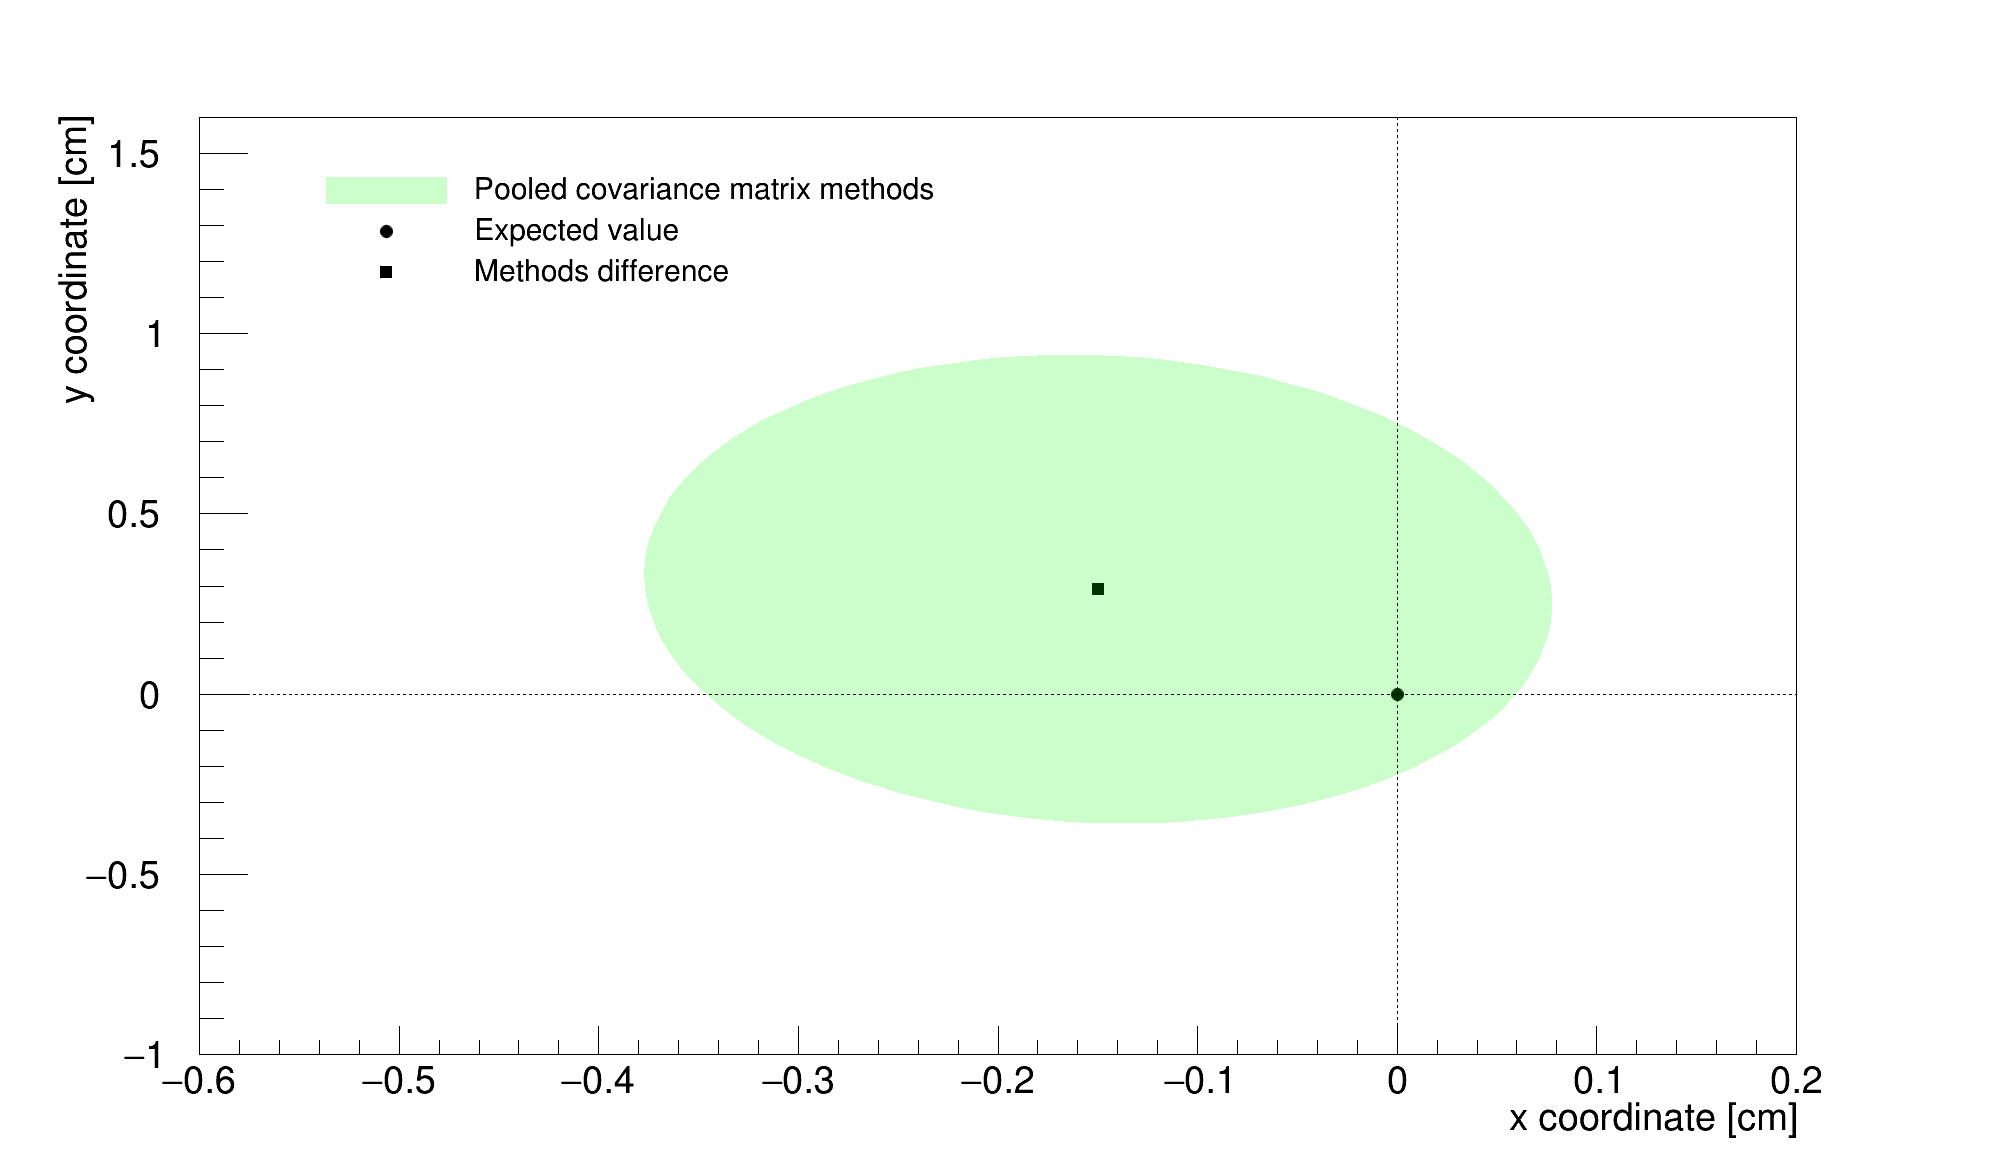

In [11]:
#NOW PLOTTING WITH RESPECT TO THE CENTER FOR BOTH ESTIMATION. PROPAGATION OF ERROR IS DONE THROUGH
#THE SUM OF THE COVARIANCE MATRICES OF THE MEASURED REAL AND THE RECONSTRUCTED ONE.
#WE KNOW THE REAL VALUE IS IN 0,0 DIFFERENCE.

legend = ROOT.TLegend(0.15,0.75,0.5,0.89)
legend.SetHeader("", "C")
legend.SetLineWidth(0)

x_t1 = x1-x2

cov_1 = np.cov(x_cov, rowvar = True)/45
cov_2 = np.cov(np.array(x_paired_joined).T, rowvar = True)/5

#fist ellipse

cov_sum_1 = cov_1 + cov_2
eigenvalues1, eigv1 = np.linalg.eig(cov_sum_1)
maj_axis1 = np.sqrt(2.35*max(eigenvalues1))
min_axis1 = np.sqrt(2.35*min(eigenvalues1))
i1 = np.where(eigenvalues1==max(eigenvalues1))
max_eigenvector1 = eigv1[:,i1]
theta1 = mt.atan(max_eigenvector1[1][0][0]/max_eigenvector1[0][0][0])

el1 = ROOT.TEllipse(x_t1[0],x_t1[1],min_axis1,maj_axis1,0,360, theta1)
el1.SetLineColor(0)
el1.SetFillColorAlpha(ROOT.kGreen, 0.2)
el1.SetFillStyle(1100)
legend.AddEntry(el1, "Pooled covariance matrix methods", "f")

"""
#second ellipse

cov_sum_2 = cov_2 + cov_real
eigenvalues2, eigv2 = np.linalg.eig(cov_sum_2)
maj_axis2 = np.sqrt(2.35*max(eigenvalues2))
min_axis2 = np.sqrt(2.35*min(eigenvalues2))
i2 = np.where(eigenvalues2==max(eigenvalues2))
max_eigenvector2 = eigv1[:,i2]
theta2 = mt.atan(max_eigenvector2[1][0][0]/max_eigenvector2[0][0][0])

el2 = ROOT.TEllipse(x_t2[0],x_t2[1],min_axis2,maj_axis2,0,360, theta2)
el2.SetLineColor(0)
el2.SetFillColorAlpha(ROOT.kRed, 0.2)
el2.SetFillStyle(1100)
legend.AddEntry(el2, "Pooled covariance matrix paired", "f")
"""
g = ROOT.TGraph(1, np.array(0), np.array(0))
g.SetTitle('')
g.GetXaxis().SetLimits(-.6,.2)
g.GetXaxis().SetTitle('x coordinate [cm]')
g.GetYaxis().SetRangeUser(-1,1.6)
g.GetYaxis().SetTitle('y coordinate [cm]')
g.GetYaxis().SetTitleOffset(1.1)
g.SetMarkerSize(1.5)
g.SetMarkerStyle(20)
g.GetYaxis().SetLabelOffset(0.02)
legend.AddEntry(g,"Expected value", "p")

g1 = ROOT.TGraph(1, np.array(x_t1[0]), np.array(x_t1[1]))
g1.SetTitle('')
g1.GetXaxis().SetLimits(-2,1)
g1.GetXaxis().SetTitle('X[cm]')
g1.GetYaxis().SetRangeUser(-2,2.3)
g1.GetYaxis().SetTitle('y coordinate [cm]')
g1.SetMarkerSize(1.5)
g1.SetMarkerStyle(21)
legend.AddEntry(g1,"Methods difference", "p")

line1 = ROOT.TLine(0,-1,0,1.6)
line1.SetLineStyle(2)

line2 = ROOT.TLine(-.6,0,.2,0)
line2.SetLineStyle(2)

g.Draw("AP")
g1.Draw("same P")
#g2.Draw("same P")
el1.Draw()
#el2.Draw()
line1.Draw()
line2.Draw()
legend.Draw()

c.Draw()
c.SaveAs('./difference_methods.root', 'root')
c.SaveAs('./difference_methods.png', 'png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ./All_Estimates_Air.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./All_Estimates_Air.root has been created


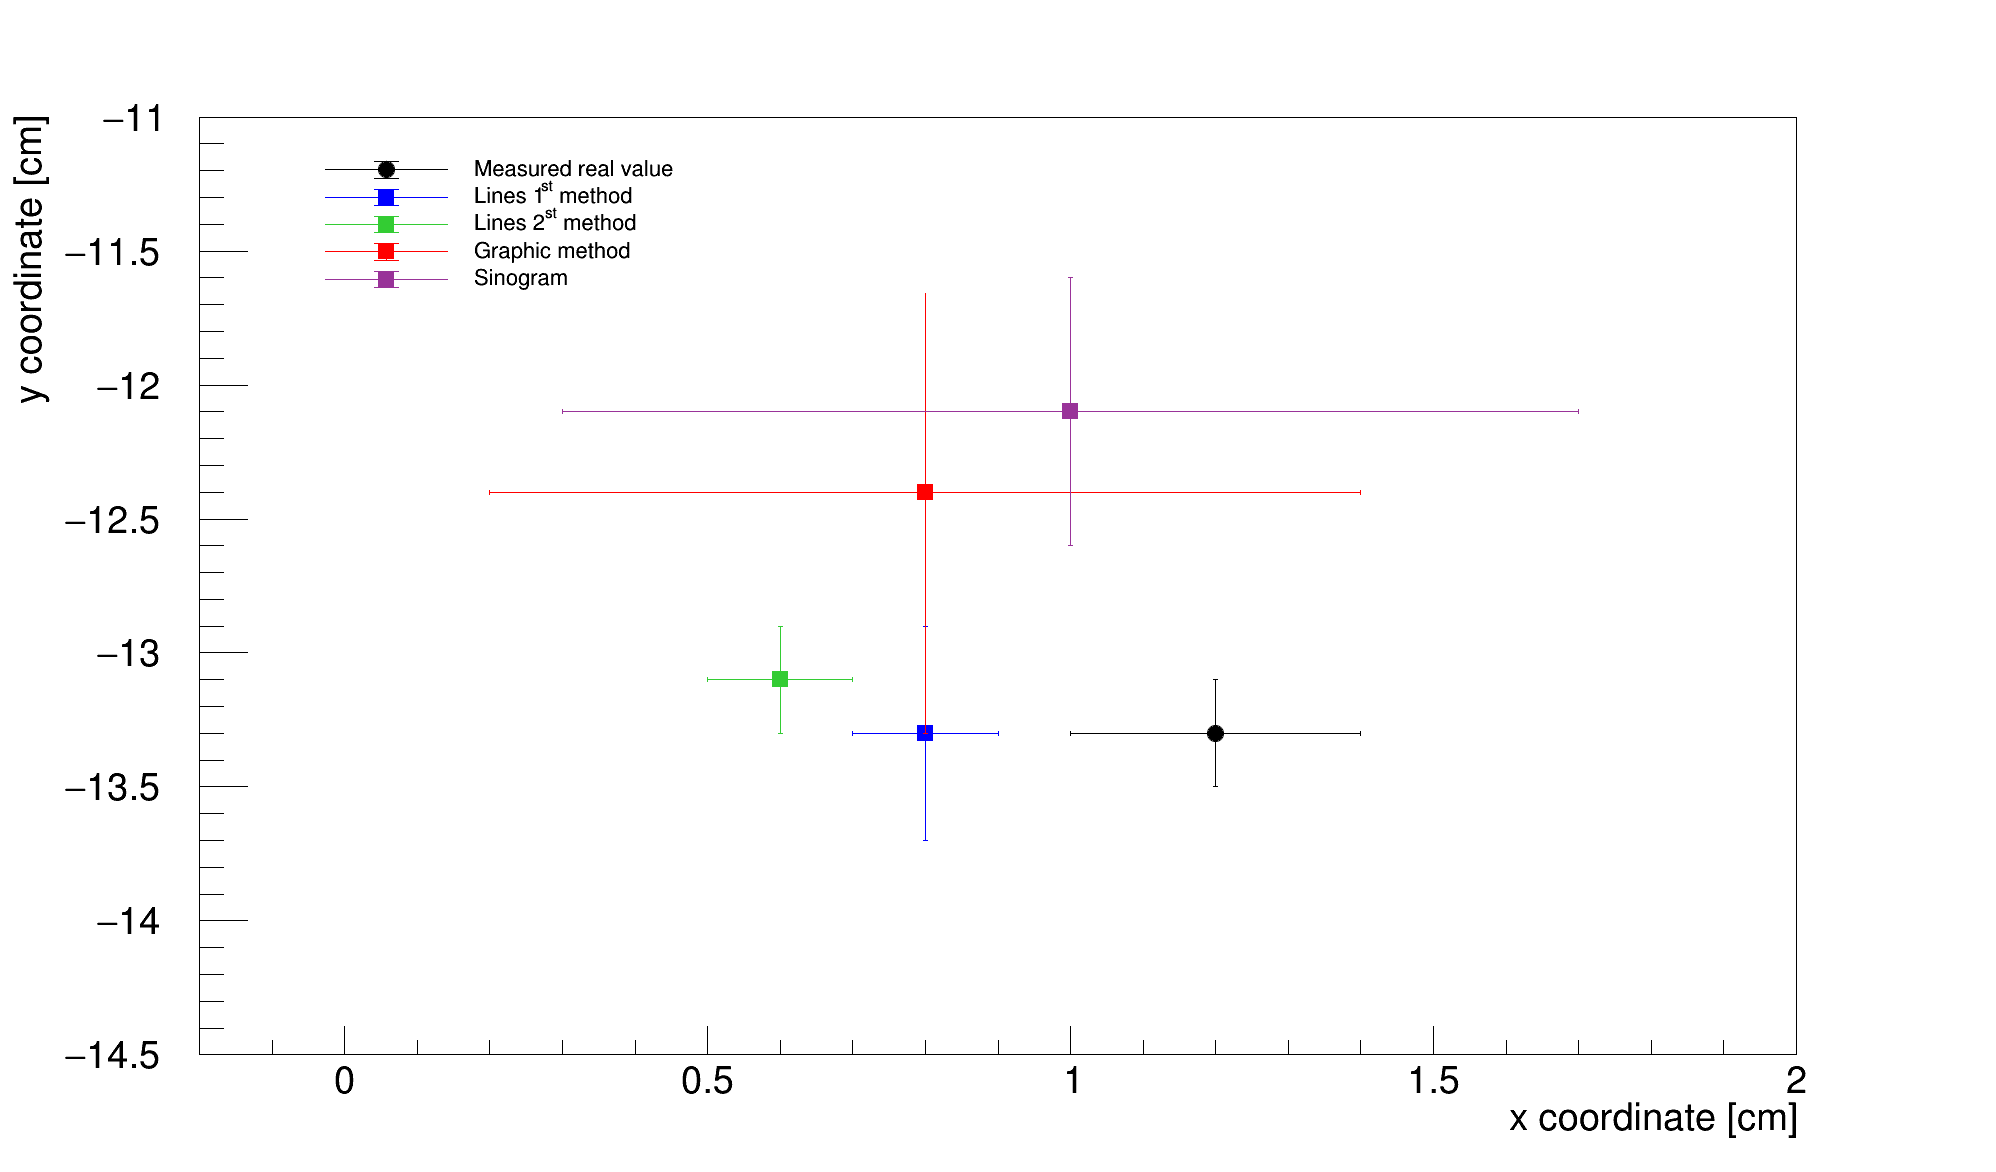

In [19]:
#NOW PLOTTING WITH RESPECT TO THE CENTER FOR BOTH ESTIMATION. PROPAGATION OF ERROR IS DONE THROUGH
#THE SUM OF THE COVARIANCE MATRICES OF THE MEASURED REAL AND THE RECONSTRUCTED ONE.
#WE KNOW THE REAL VALUE IS IN 0,0 DIFFERENCE.

c = ROOT.TCanvas("c", "c", 1000,1000,2000,1200)
legend = ROOT.TLegend(0.15,0.75,0.5,0.89)
legend.SetHeader("", "C")
legend.SetLineWidth(0)


g = ROOT.TGraphErrors(1, np.array(1.2), np.array(-13.3), np.array(0.2), np.array(0.2))
g.SetTitle()
g.GetXaxis().SetLimits(-.2,2)
g.GetXaxis().SetTitle('x coordinate [cm]')
g.GetYaxis().SetRangeUser(-14.5,-11)
g.GetYaxis().SetTitle('y coordinate [cm]')
g.GetYaxis().SetTitleOffset(1.5)
g.SetMarkerSize(2)
g.SetMarkerStyle(20)
#g.SetLineColor(ROOT.kRed)
#g.SetMarkerColor(ROOT.kRed)
g.GetYaxis().SetLabelOffset(0.02)
legend.AddEntry(g,"Measured real value", "pel")

line1_x = ROOT.TLine(1.2-0.4,-13.3,1.2+0.4,-13.3)
line1_x.SetLineStyle(2)
line1_x.SetLineWidth(2)
line1_y = ROOT.TLine(1.2,-13.3-0.4,1.2,-13.3+0.4)
line1_y.SetLineStyle(2)
line1_y.SetLineWidth(2)


g1 = ROOT.TGraphErrors(1, np.array(0.8), np.array(-13.3), np.array(0.1), np.array(0.4))
g1.SetTitle('')
g1.GetYaxis().SetTitle('y coordinate [cm]')
g1.SetMarkerSize(2)
g1.SetMarkerStyle(21)
g1.SetLineColor(ROOT.kBlue)
g1.SetMarkerColor(ROOT.kBlue)
legend.AddEntry(g1,"Lines 1^{st} method", "pel")

line2_x = ROOT.TLine(0.8-0.2,-13.3,0.8+0.2,-13.3)
line2_x.SetLineStyle(2)
line2_x.SetLineWidth(2)
line2_x.SetLineColor(ROOT.kBlue)
line2_y = ROOT.TLine(0.8,-13.3-0.8,0.8,-13.3+0.8)
line2_y.SetLineStyle(2)
line2_y.SetLineWidth(2)
line2_y.SetLineColor(ROOT.kBlue)

g2 = ROOT.TGraphErrors(1, np.array(0.6), np.array(-13.1), np.array(0.1), np.array(0.2))
g2.SetTitle('')
g2.GetYaxis().SetTitle('y coordinate [cm]')
g2.SetMarkerSize(2)
g2.SetMarkerStyle(21)
g2.SetLineColor(ROOT.kGreen-3)
g2.SetMarkerColor(ROOT.kGreen-3)
legend.AddEntry(g2,"Lines 2^{st} method", "pel")

line3_x = ROOT.TLine(0.6-0.2,-13.1,0.6+0.2,-13.1)
line3_x.SetLineStyle(2)
line3_x.SetLineWidth(2)
line3_x.SetLineColor(ROOT.kGreen-3)
line3_y = ROOT.TLine(0.6,-13.1-0.4,0.6,-13.1+0.4)
line3_y.SetLineStyle(2)
line3_y.SetLineWidth(2)
line3_y.SetLineColor(ROOT.kGreen-3)

g3 = ROOT.TGraphErrors(1, np.array(0.8), np.array(-12.4), np.array(0.6), np.array(0.9))
g3.SetTitle('')
g3.GetYaxis().SetTitle('y coordinate [cm]')
g3.SetMarkerSize(2)
g3.SetMarkerStyle(21)
g3.SetLineColor(ROOT.kRed)
g3.SetMarkerColor(ROOT.kRed)
legend.AddEntry(g3,"Graphic method", "pel")


line4_x = ROOT.TLine(0.8-1.2,-12.4,0.8+1.2,-12.4)
line4_x.SetLineStyle(2)
line4_x.SetLineWidth(2)
line4_x.SetLineColor(ROOT.kRed)
line4_y = ROOT.TLine(0.8,-12.4-1.8,0.8,-12.4+1.8)
line4_y.SetLineStyle(2)
line4_y.SetLineWidth(2)
line4_y.SetLineColor(ROOT.kRed)


g4 = ROOT.TGraphErrors(1, np.array(1.0), np.array(-12.1), np.array(0.7), np.array(0.5))
g4.SetTitle('')
g4.GetYaxis().SetTitle('y coordinate [cm]')
g4.SetMarkerSize(2)
g4.SetMarkerStyle(21)
g4.SetLineColor(ROOT.kMagenta-2)
g4.SetMarkerColor(ROOT.kMagenta-2)
legend.AddEntry(g4,"Sinogram", "pel")

line5_x = ROOT.TLine(1-1.4,-12.1,1+1.4,-12.1)
line5_x.SetLineStyle(2)
line5_x.SetLineWidth(2)
line5_x.SetLineColor(ROOT.kMagenta-2)
line5_y = ROOT.TLine(1,-12.1-1.4,1,-12.1+1.4)
line5_y.SetLineStyle(2)
line5_y.SetLineWidth(2)
line5_y.SetLineColor(ROOT.kMagenta-2)


g.Draw("AP")
"""
line1_x.Draw()
line1_y.Draw()
line2_x.Draw()
line2_y.Draw()
line3_x.Draw()
line3_y.Draw()
line4_x.Draw()
line4_y.Draw()
line5_x.Draw()
line5_y.Draw()
"""
g1.Draw("same P")
g2.Draw("same P")
g3.Draw("same P")
g4.Draw("same P")


legend.Draw()

c.Draw()
c.SaveAs("./All_Estimates_Air.png", ".png")
c.SaveAs("./All_Estimates_Air.root", ".root")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ./All_Estimates_Water.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./All_Estimates_Water.root has been created


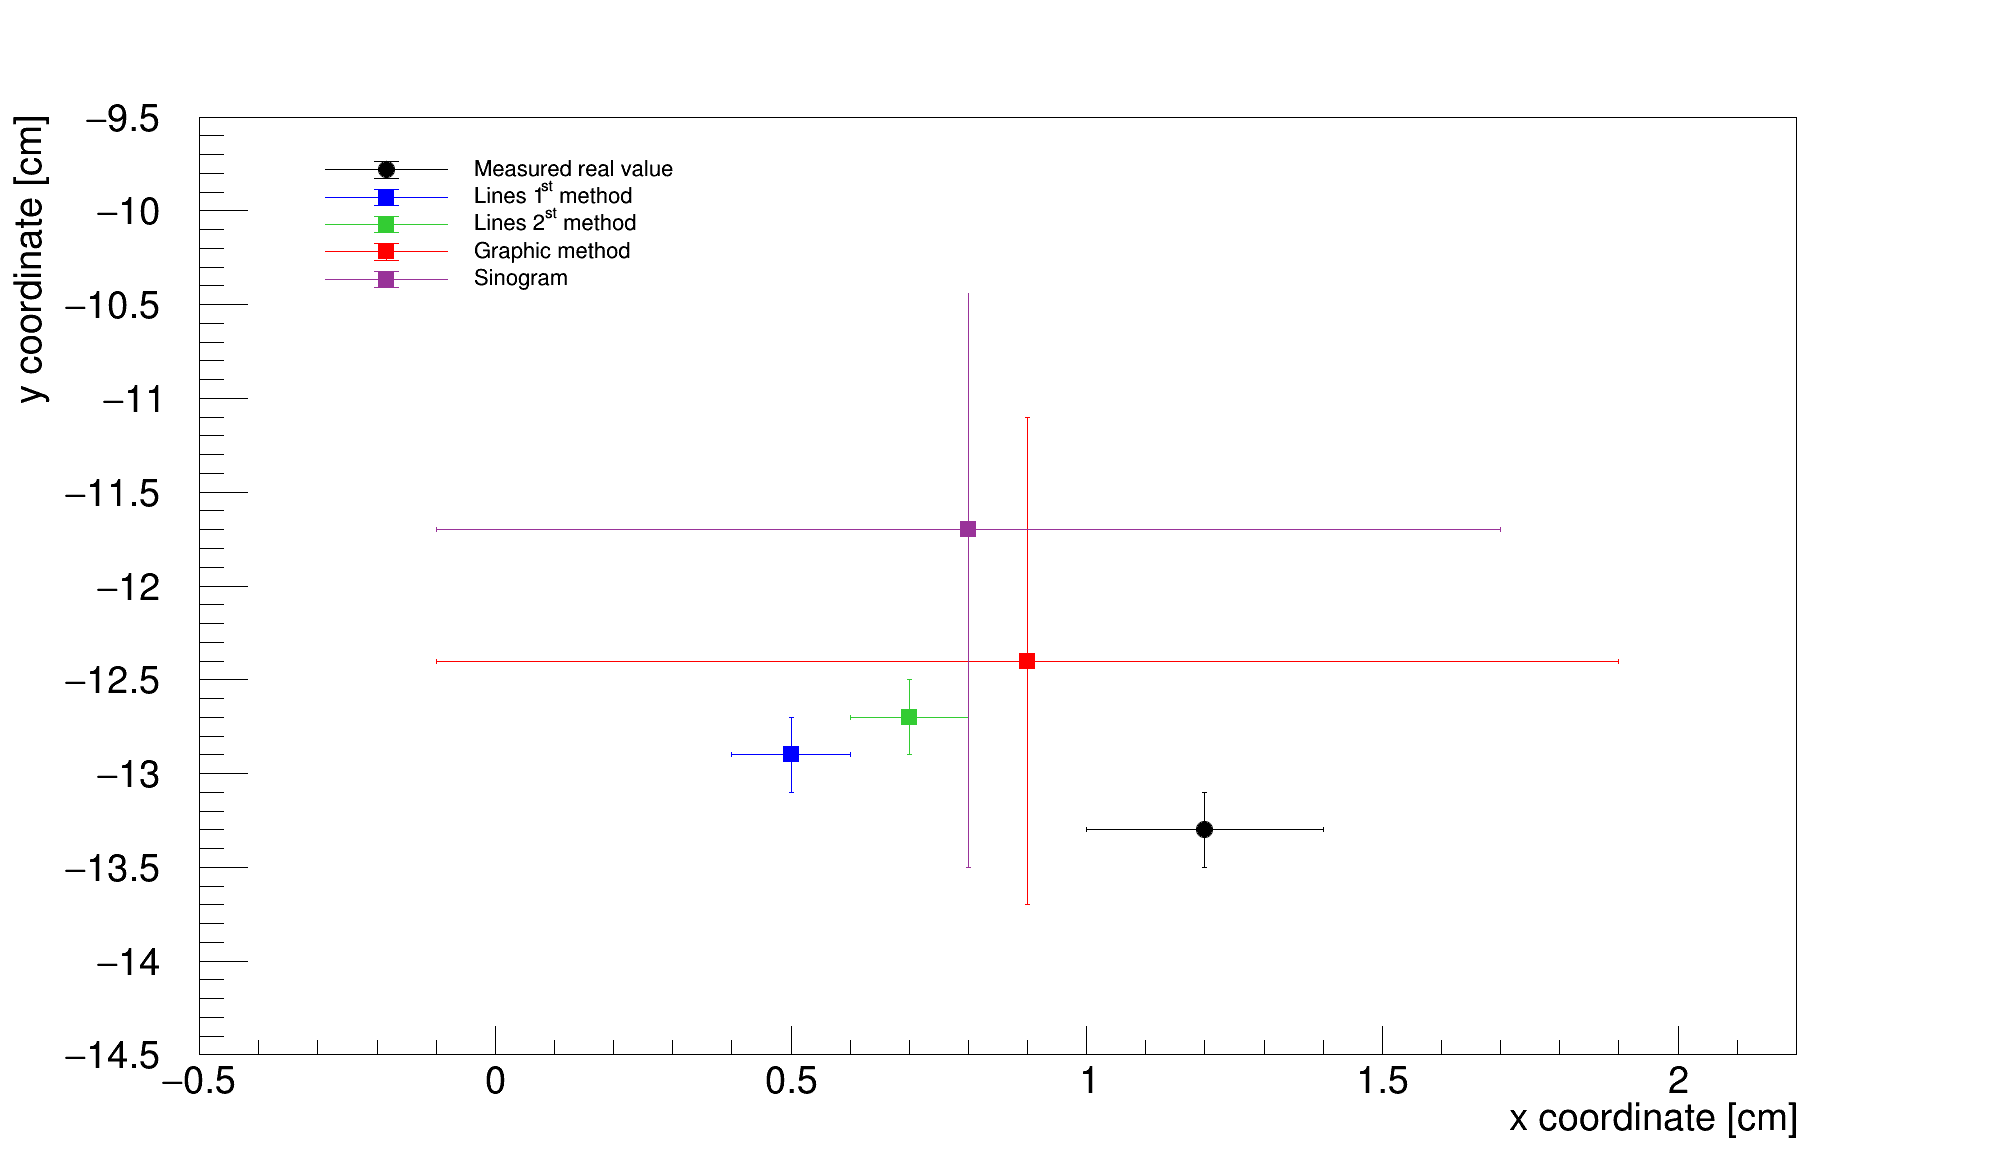

In [18]:
#NOW PLOTTING WITH RESPECT TO THE CENTER FOR BOTH ESTIMATION. PROPAGATION OF ERROR IS DONE THROUGH
#THE SUM OF THE COVARIANCE MATRICES OF THE MEASURED REAL AND THE RECONSTRUCTED ONE.
#WE KNOW THE REAL VALUE IS IN 0,0 DIFFERENCE.

c = ROOT.TCanvas("c", "c", 1000,1000,2000,1200)
legend = ROOT.TLegend(0.15,0.75,0.5,0.89)
legend.SetHeader("", "C")
legend.SetLineWidth(0)


g = ROOT.TGraphErrors(1, np.array(1.2), np.array(-13.3), np.array(0.2), np.array(0.2))
g.SetTitle()
g.GetXaxis().SetLimits(-0.5,2.2)
g.GetXaxis().SetTitle('x coordinate [cm]')
g.GetYaxis().SetRangeUser(-14.5,-9.5)
g.GetYaxis().SetTitle('y coordinate [cm]')
g.GetYaxis().SetTitleOffset(1.5)
g.SetMarkerSize(2)
g.SetMarkerStyle(20)
#g.SetLineColor(ROOT.kRed)
#g.SetMarkerColor(ROOT.kRed)
g.GetYaxis().SetLabelOffset(0.02)
legend.AddEntry(g,"Measured real value", "pel")

g1 = ROOT.TGraphErrors(1, np.array(0.5), np.array(-12.9), np.array(0.1), np.array(0.2))
g1.SetTitle('')
g1.GetYaxis().SetTitle('y coordinate [cm]')
g1.SetMarkerSize(2)
g1.SetMarkerStyle(21)
g1.SetLineColor(ROOT.kBlue)
g1.SetMarkerColor(ROOT.kBlue)
legend.AddEntry(g1,"Lines 1^{st} method", "pel")

g2 = ROOT.TGraphErrors(1, np.array(0.7), np.array(-12.7), np.array(0.1), np.array(0.2))
g2.SetTitle('')
g2.GetYaxis().SetTitle('y coordinate [cm]')
g2.SetMarkerSize(2)
g2.SetMarkerStyle(21)
g2.SetLineColor(ROOT.kGreen-3)
g2.SetMarkerColor(ROOT.kGreen-3)
legend.AddEntry(g2,"Lines 2^{st} method", "pel")

g3 = ROOT.TGraphErrors(1, np.array(0.9), np.array(-12.4), np.array(1.), np.array(1.3))
g3.SetTitle('')
g3.GetYaxis().SetTitle('y coordinate [cm]')
g3.SetMarkerSize(2)
g3.SetMarkerStyle(21)
g3.SetLineColor(ROOT.kRed)
g3.SetMarkerColor(ROOT.kRed)
legend.AddEntry(g3,"Graphic method", "pel")

g4 = ROOT.TGraphErrors(1, np.array(0.8), np.array(-11.7), np.array(0.9), np.array(1.8))
g4.SetTitle('')
g4.GetYaxis().SetTitle('y coordinate [cm]')
g4.SetMarkerSize(2)
g4.SetMarkerStyle(21)
g4.SetLineColor(ROOT.kMagenta-2)
g4.SetMarkerColor(ROOT.kMagenta-2)
legend.AddEntry(g4,"Sinogram", "pel")



g.Draw("AP")
g1.Draw("same P")
g2.Draw("same P")
g3.Draw("same P")
g4.Draw("same P")


legend.Draw()

c.Draw()
c.SaveAs("./All_Estimates_Water.png", ".png")
c.SaveAs("./All_Estimates_Water.root", ".root")